# Анализ посещаемости в школах. 

## Часть 0: обзор датафрейма и исследовательский анализ.

**ВНИМАНИЕ! Код в данном файле во время исполнения считывает локальные данные.**

Цель: провести исследовательский анализ данных, очистить данные и подготовить к построению моделей машинного обучения.

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from datetime import timedelta, datetime

%matplotlib inline

In [2]:
df_filename = './data/2018-2019_Daily_Attendance_20240429.csv.zip'

### 1. Загрузка данных и первичный осмотр

In [3]:
df = pd.read_csv(df_filename, compression='zip')

In [4]:
df.head()

,School DBN,Date,Enrolled,Absent,Present,Released
0,01M015,20180905,172,19,153,0
1,01M015,20180906,171,17,154,0
2,01M015,20180907,172,14,158,0
3,01M015,20180912,173,7,166,0
4,01M015,20180913,173,9,164,0


Данные представляют собой записи о посещаемости -- число зарегистрированных/присутствующих/отсутствующих/освобожденных студентов.

In [5]:
print(f'Число дубликатов: {df.duplicated().sum()}. \n')

print('Количество пропусков по каждому из столбцов:', df.isna().sum(), sep='\n')

Число дубликатов: 0. 

Количество пропусков по каждому из столбцов:
School DBN    0
Date          0
Enrolled      0
Absent        0
Present       0
Released      0
dtype: int64


Дубликаты и пропуски не найдены -- данные уже очищены.

### 2. Преобразование форматов и очистка от выбросов.

Можно заметить, что формат даты -- просто строки. Преобразуем к хорошему виду.

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [7]:
df.sample(3)

,School DBN,Date,Enrolled,Absent,Present,Released
161680,19K677,2019-01-22,524,79,445,0
185060,23K155,2019-05-21,439,46,393,0
268401,75K369,2019-06-19,536,74,437,25


Работать с абсолютными величинами неудобно, так как число обучающихся в школах может разниться. Поэтому добавим столбцы, содержащие процент посещаемости, прогулов и освобождений как соответствующие отношения пришедших, отсутствующих и освобожденных человек к числу зарегистрированных. 

In [8]:
df['Present pct'] = 100 * df['Present'] / df['Enrolled']
df['Absent pct'] = 100 * df['Absent'] / df['Enrolled']
df['Released pct'] = 100 * df['Released'] / df['Enrolled']

In [9]:
df.sample(3)

,School DBN,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct
172849,21K209,2019-03-07,719,45,674,0,93.741307,6.258693,0.0
107132,12X195,2019-06-17,900,93,807,0,89.666667,10.333333,0.0
30657,03M404,2019-05-15,165,54,111,0,67.272727,32.727273,0.0


Проанализируем данные об относительной посещаемости на наличие выбросов и очистим данные от них.

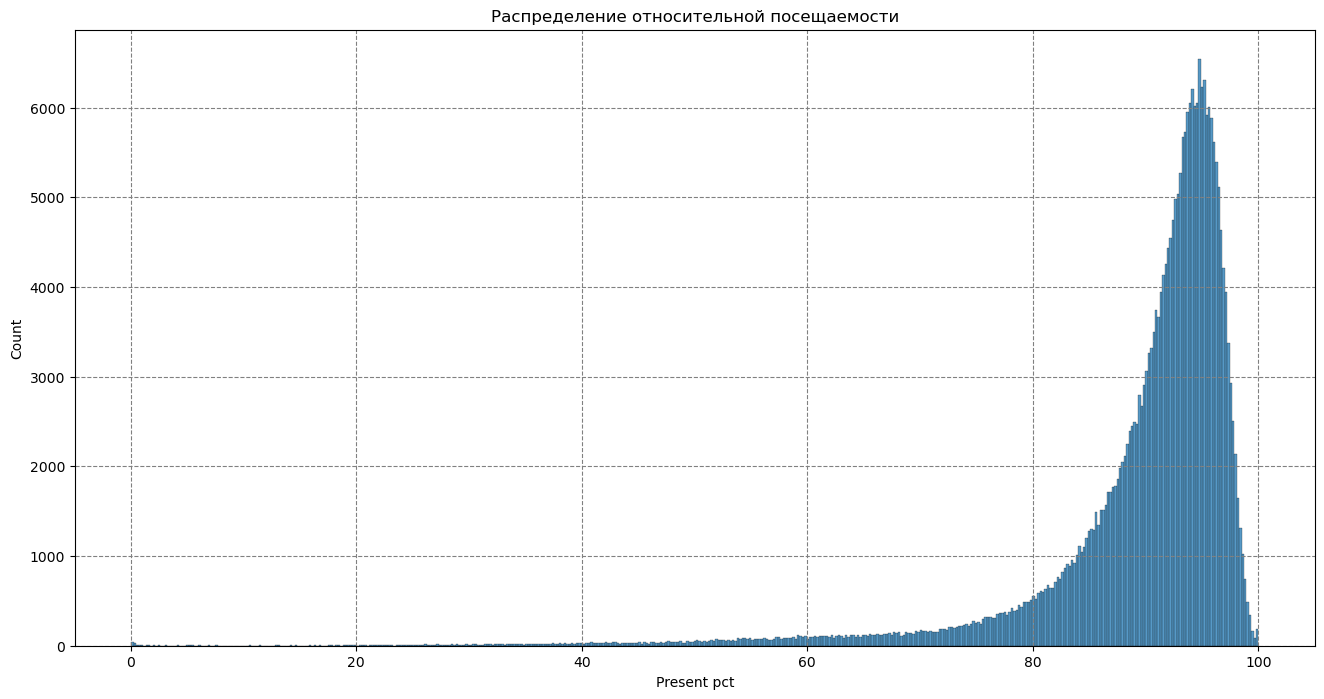

In [10]:
plt.subplots(figsize=(16, 8))

sns.histplot(data=df, x='Present pct')

plt.grid(True, color='grey', linestyle='--')
plt.title('Распределение относительной посещаемости')

plt.show()

Видно, что распределение несимметрично и имеет длинный хвост слева. Поэтому использование z-score для выявления выбросов нежелателен. Будем использовать межквартальное расстояние.

In [11]:
iqr = df['Present pct'].quantile(.75) - df['Present pct'].quantile(.25)

median = df['Present pct'].median()

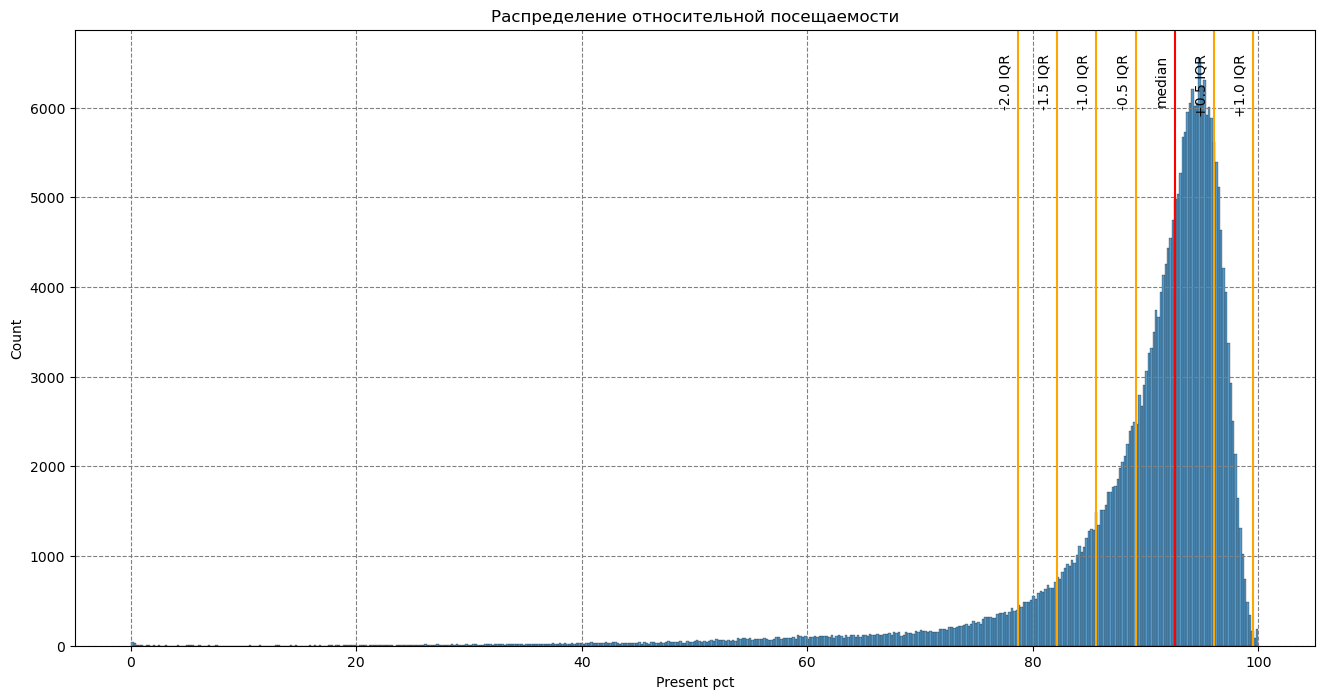

In [12]:
plt.subplots(figsize=(16, 8))

sns.histplot(data=df, x='Present pct')

plt.axvline(x=median, color='Red')
plt.text(x=median - 0.5, y=6600, s=f'median', rotation='vertical',
         horizontalalignment='right', verticalalignment='top')

for coeff in [0.5, 1.0, 1.5, 2.0]:
    lower = median - coeff * iqr
    if lower > 0:
        plt.axvline(x=lower, color='Orange')
        plt.text(x=lower - 0.5, y=6600, s=f'-{coeff} IQR', rotation='vertical',
                 horizontalalignment='right', verticalalignment='top')

    upper = median + coeff * iqr
    if upper < 100:
        plt.axvline(x=upper, color='Orange')
        plt.text(x=upper - 0.5, y=6600, s=f'+{coeff} IQR', rotation='vertical',
                 horizontalalignment='right', verticalalignment='top')

plt.grid(True, color='grey', linestyle='--')
plt.title('Распределение относительной посещаемости')
plt.show()

Возьмем ширину окна немного больше, чем обычно -- 2 межквартальных расстояния от медианы.

In [13]:
outliers = (df['Present pct'] < median - 2 * iqr) | (median + 2 * iqr < df['Present pct'])

df_outliers = df[outliers]
df = df[~outliers]

Оценить качество очистки поможет boxplot.

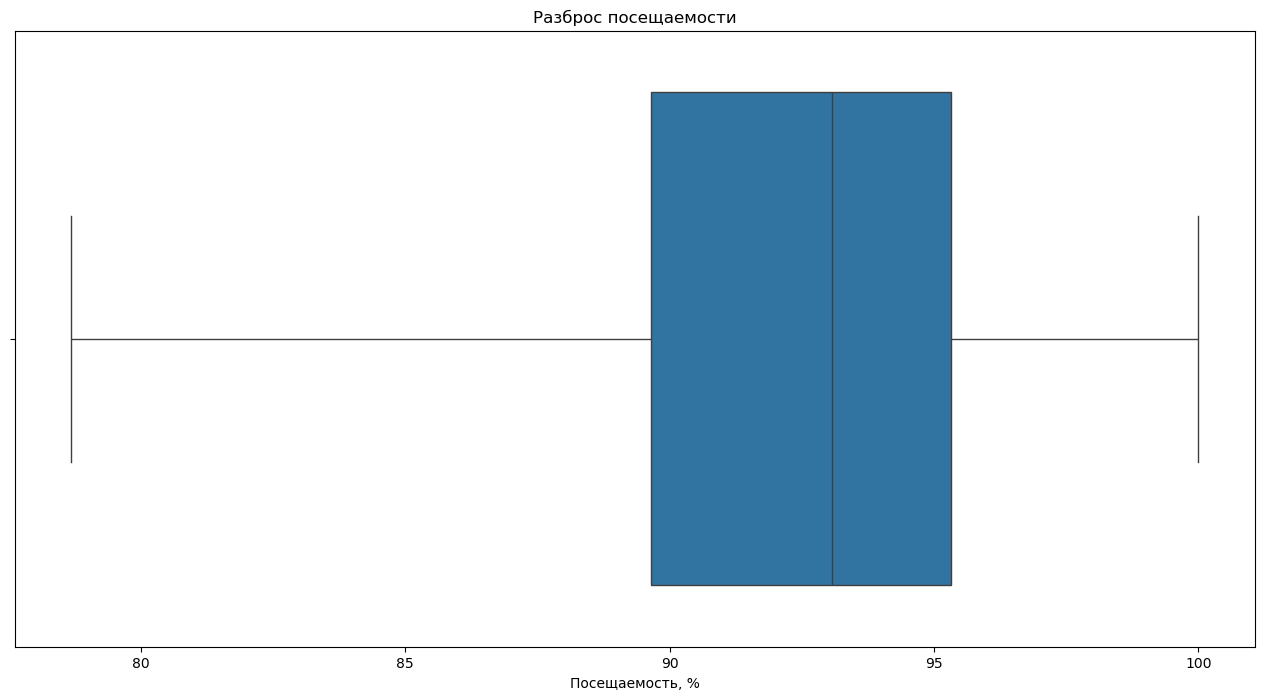

In [14]:
plt.subplots(figsize=(16, 8))

sns.boxplot(data=df, x='Present pct', whis=2)
plt.xlabel(xlabel='Посещаемость, %')
plt.title('Разброс посещаемости')
plt.show()

Видно, что все отобранные значения лежат в двухмежквартальном окне вокруг медианы.

### 3. Временной анализ посещаемости 

In [15]:
# Число представленных в датафрейме школ
print(df['School DBN'].unique().shape[0])

# Проверка через приведение к нижнему регистру. Судя по всему, в датафрейме, действительно, 1550 различные школы.
print(len(set(map(str.lower, df['School DBN']))))

1559
1559


Создадим дополнительный датафрейм, аггрегированный суммированием по всем школам.

In [16]:
print(*df.columns, sep=' | ')

School DBN | Date | Enrolled | Absent | Present | Released | Present pct | Absent pct | Released pct


In [17]:
df_sum = df.loc[:,'Date':'Released'].groupby(by='Date', as_index=False).sum()

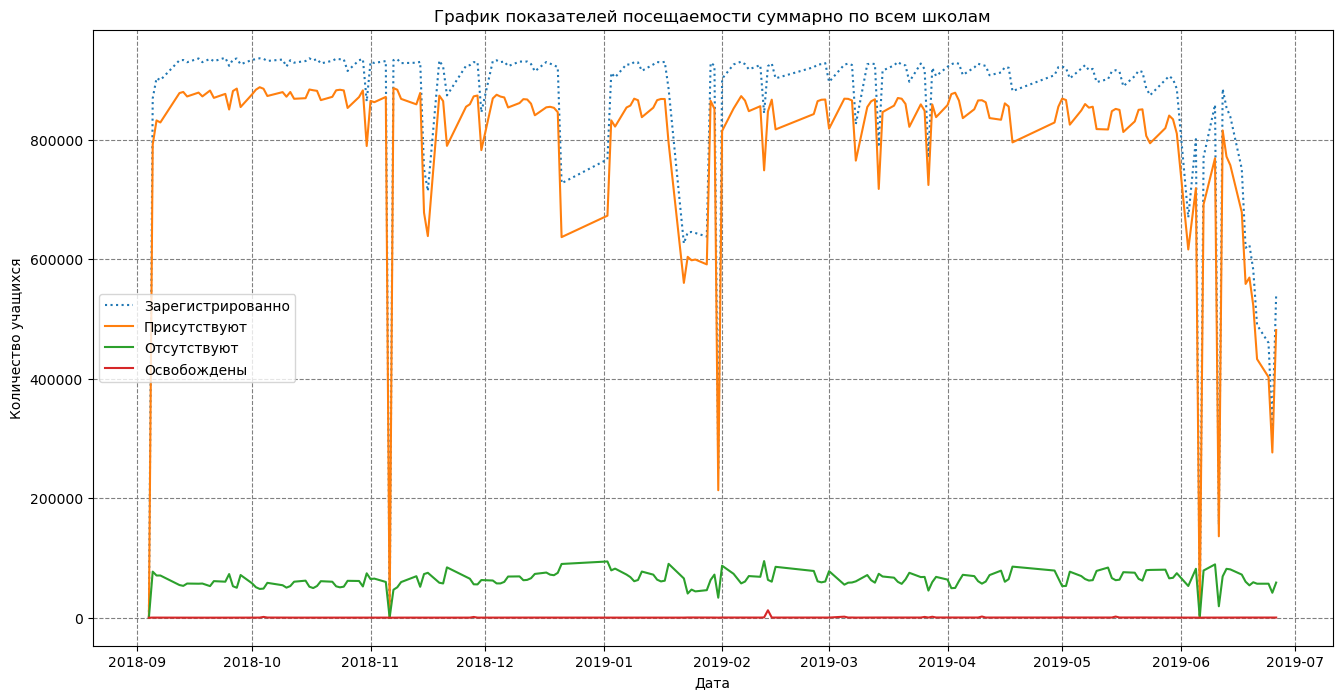

In [18]:
plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_sum, x='Date', y='Enrolled', linestyle='dotted', label='Зарегистрированно')
sns.lineplot(data=df_sum, x='Date', y='Present', label='Присутствуют')
sns.lineplot(data=df_sum, x='Date', y='Absent', label='Отсутствуют')
sns.lineplot(data=df_sum, x='Date', y='Released', label='Освобождены')


plt.xlabel(xlabel='Дата')
plt.ylabel(ylabel='Количество учащихся')


plt.title('График показателей посещаемости суммарно по всем школам')
plt.grid(True, color='grey', linestyle='--')

plt.show()

В абсолютных суммарных величинах видны "провалы" в посещаемости, но показанный график ничего не говорит об относительной посещаемости. Пересчитаем все в долях и построим график в процентах.

In [19]:
df_sum['Present pct'] = 100 * df_sum['Present'] / df_sum['Enrolled']
df_sum['Absent pct'] = 100 * df_sum['Absent'] / df_sum['Enrolled']
df_sum['Released pct'] = 100 *  df_sum['Released'] / df_sum['Enrolled']

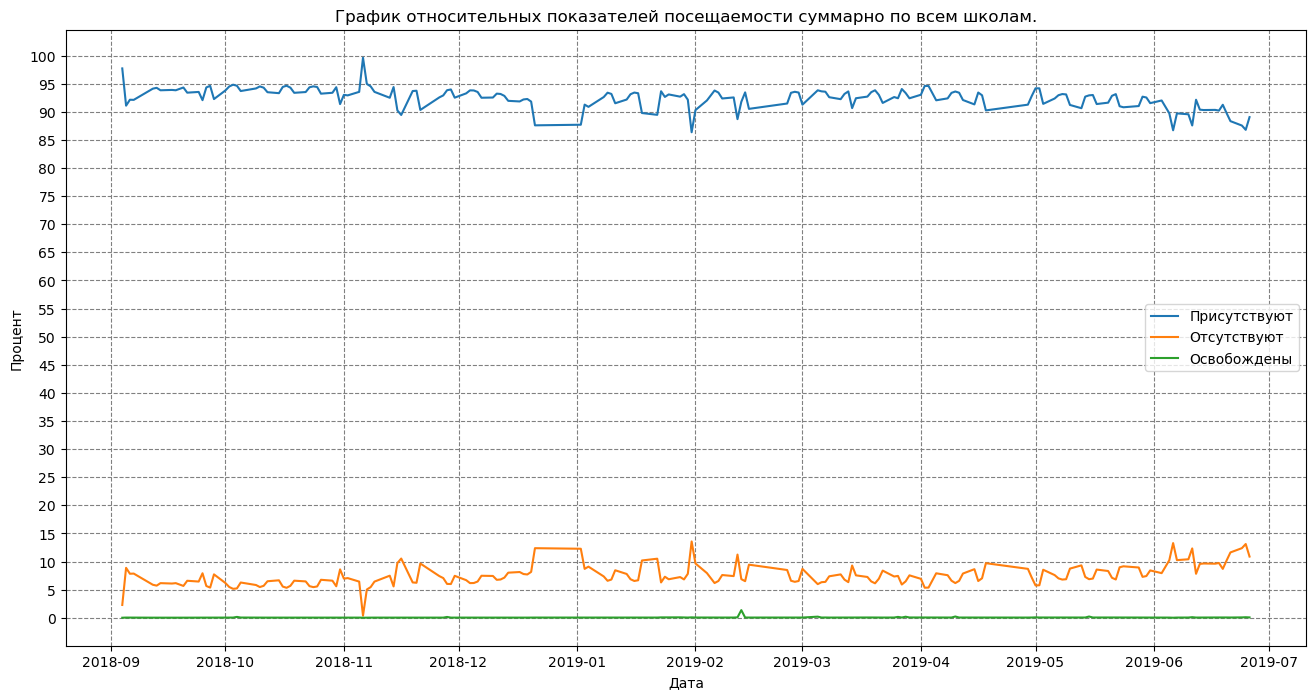

In [20]:
plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_sum, x='Date', y='Present pct', label='Присутствуют')
sns.lineplot(data=df_sum, x='Date', y='Absent pct', label='Отсутствуют')
sns.lineplot(data=df_sum, x='Date', y='Released pct', label='Освобождены')

plt.yticks(ticks=range(0, 100+1, 5))
plt.xlabel(xlabel='Дата')
plt.ylabel(ylabel='Процент')

plt.grid(True, color='grey', linestyle='--')
plt.title('График относительных показателей посещаемости суммарно по всем школам.')
plt.show()

Видны интересные особенности:
1. Существуют локальные пики доли как посещаемости так и пропусков;
2. Периодические осцилляции доли прогульщиков (возможно, посещаемость меняется в течение недели).

Кроме того, относительная посещаемость выглядит более стабильной и "ровной", чем данные об абсолютной посещаемости.

Выясним сначала, чем определены пики прогульщиков. Для этого выделим их пороговым значением, оценив его по графику распределения.

Мы считаем наиболее целесообразным пороговое значение в 10% прогульщиков. Выделим их в отдельный датафрейм df_high_absence.

In [21]:
df_high_absence = df_sum[df_sum['Absent pct'] >= 10]

In [22]:
display(df_high_absence, df_high_absence.shape[0])

,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct
48,2018-11-16,713932,75156,638579,197,89.445353,10.527053,0.027594
71,2018-12-21,726995,89944,636850,201,87.600327,12.372025,0.027648
72,2019-01-02,766970,94113,672694,163,87.707994,12.270754,0.021252
84,2019-01-18,885162,90148,794782,232,89.789440,10.184350,0.026210
85,2019-01-22,626183,65751,560248,184,89.470331,10.500285,0.029384
92,2019-01-31,246973,33504,213312,157,86.370575,13.565855,0.063570
99,2019-02-12,843924,94787,748572,565,88.701352,11.231699,0.066949
166,2019-06-05,800712,81866,718648,198,89.751122,10.224151,0.024728
167,2019-06-06,994,132,862,0,86.720322,13.279678,0.000000
168,2019-06-07,770669,78968,691488,213,89.725680,10.246682,0.027638


17

Получили 10 дней, в которые наблюдались самые высокиие в среднем значения пропусков. Проверим, сколько из выявленных дней выпадают на праздники (ограничимся федеральными праздничными днями США).

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as us_holidays

holidays = us_holidays().holidays(start=df['Date'].min(), end=df['Date'].max(), return_name=True)

df_sum['Holiday'] =  df_sum['Date'].isin(holidays)

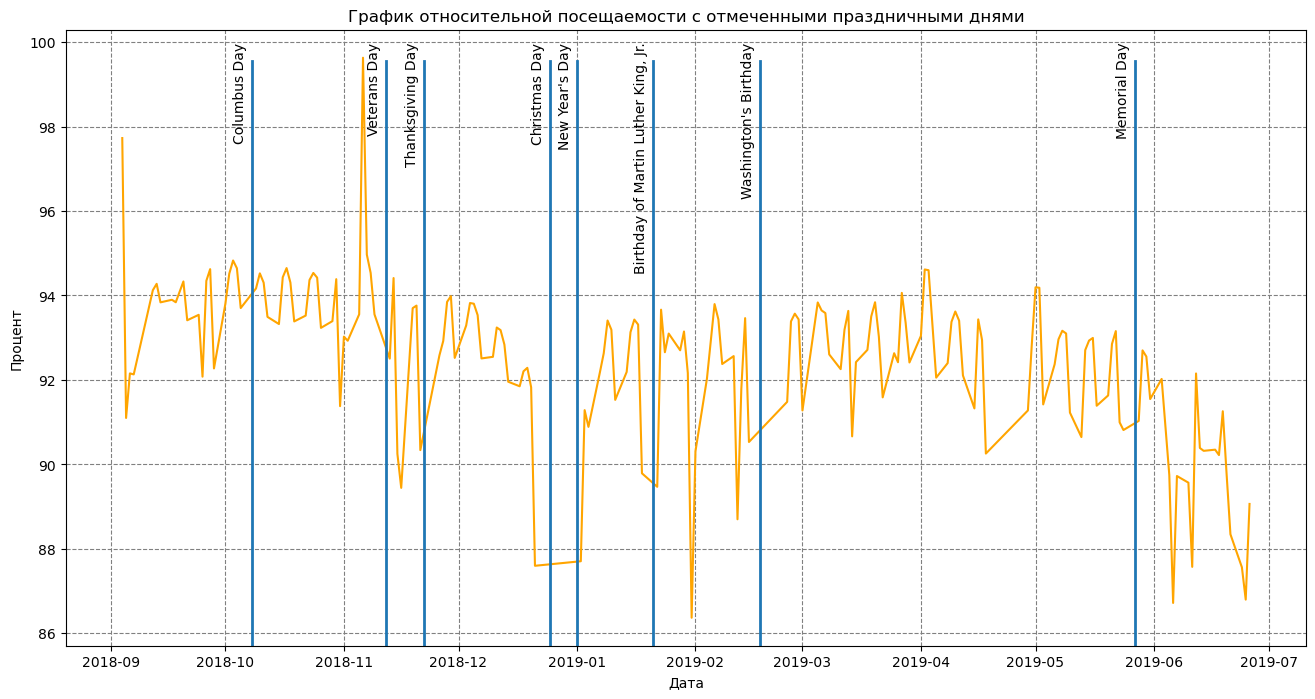

In [24]:
plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_sum, x='Date', y='Present pct', color='orange')

plt.xlabel(xlabel='Дата')
plt.ylabel(ylabel='Процент')

for date in holidays.index:
    plt.axvline(date, ymin=0, ymax=0.95, linewidth=2)
    plt.text(x=date-timedelta(days=5), y=100, s=holidays[date], rotation='vertical', verticalalignment='top')

plt.grid(True, color='grey', linestyle='--')

plt.title('График относительной посещаемости с отмеченными праздничными днями')
plt.show()

Мы можем наблюдать, что пики прогулов приходятся на окрестности двух крупных праздников: Дня Благодарения и Рождества. Так же посещаемость снижается перед днем рождения Мартина Лютера Кинга (нам тяжело дедать выводы о причастности празника к причинам этого явления). Падение посещаемости 31 января остается под вопросом.

Ожидаемо, в конце учебного года посещаемость падает.

### 3. Осцилляции посещаемости.

Пронаблюдаем характер изменения посещаемости в течение недели (в среднем и в медиане).

In [25]:
df_sum.head()

,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct,Holiday
0,2018-09-04,264,6,258,0,97.727273,2.272727,0.000000,False
1,2018-09-05,869010,77116,791672,222,91.100448,8.874006,0.025546,False
2,2018-09-06,902879,70639,832053,187,92.155538,7.823750,0.020712,False
3,2018-09-07,899452,70641,828679,132,92.131542,7.853782,0.014676,False
4,2018-09-12,932662,54697,877865,100,94.124667,5.864611,0.010722,False


In [26]:
df_sum['Day of week'] = df_sum['Date'].dt.day_of_week

df_sum_weekly = df_sum.groupby(by='Day of week', as_index=False).agg({column: ['median', 'mean'] for column in df_sum.columns[1:-2]})
day_names = ['ПН', 'ВТ', 'СР', 'ЧТ', 'ПТ', 'СБ', 'ВС']

df_sum_weekly['Day name'] = df_sum_weekly['Day of week'].map(lambda x: day_names[x])

In [27]:
df_sum_weekly.head()

Day of week  Enrolled                  Absent                 Present  \
                 median           mean   median          mean    median   
0           0  925141.0  885846.750000  68386.0  67517.781250  854208.5   
1           1  925308.5  817091.750000  60987.5  57598.472222  860049.5   
2           2  924461.0  884494.461538  58636.0  60450.461538  866659.0   
3           3  924472.5  854708.578947  60539.5  59902.973684  863554.5   
4           4  902475.0  871366.108108  71423.0  71080.081081  824959.0   

                 Released             Present pct            Absent pct  \
            mean   median        mean      median       mean     median   
0  818059.625000    262.5  269.343750   92.473382  92.249387   7.496052   
1  759181.305556    220.0  311.972222   93.167454  92.928047   6.794231   
2  823356.564103    272.0  687.435897   93.569656  92.989229   6.389532   
3  794495.578947    246.0  310.026316   93.249596  92.593112   6.728946   
4  800034.891892    242.0  251.135135   92.055107  91.723759   7.904918   

            Released pct           Day name  
       mean       median      mean           
0  7.719196     0.028496  0.031418       ПН  
1  7.033603     0.031738  0.038350       ВТ  
2  6.934392     0.029726  0.076379       СР  
3  7.370879     0.030100  0.036008       ЧТ  
4  8.247041     0.027648  0.029201       ПТ

In [28]:
df_sum_weekly.columns = [' '.join(column).strip() for column in df_sum_weekly.columns.values]

In [29]:
print(*df_sum_weekly.columns, sep='\n')

Day of week
Enrolled median
Enrolled mean
Absent median
Absent mean
Present median
Present mean
Released median
Released mean
Present pct median
Present pct mean
Absent pct median
Absent pct mean
Released pct median
Released pct mean
Day name


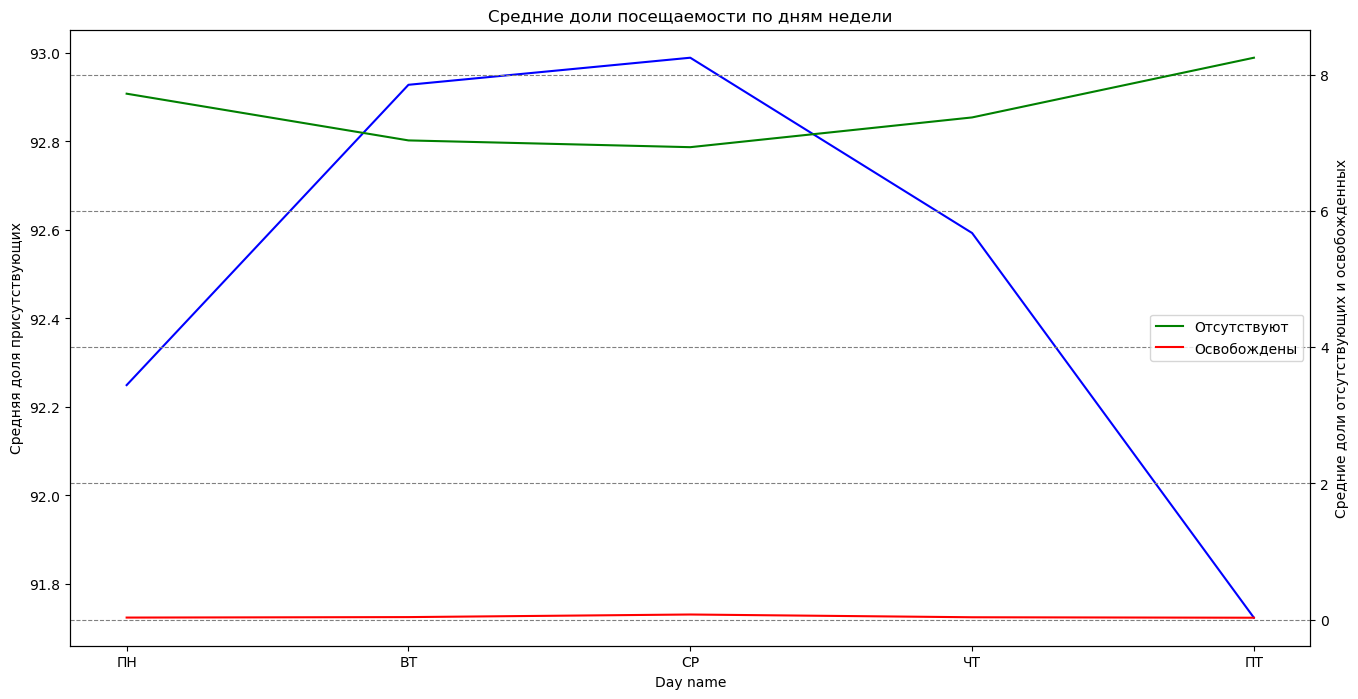

In [30]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Left axes
sns.lineplot(data=df_sum_weekly,
             x='Day name', y='Present pct mean',
             ax=ax1, label='Присутствуют', color='Blue')
ax1.set_ylabel('Средняя доля присутствующих')

ax2 = plt.twinx()
sns.lineplot(data=df_sum_weekly, 
             x='Day name', y='Absent pct mean',
             ax=ax2, label='Отсутствуют', color='Green')
sns.lineplot(data=df_sum_weekly, 
             x='Day name', y='Released pct mean',
             ax=ax2, label='Освобождены', color='Red')

ax2.set_ylabel('Средние доли отсутствующих и освобожденных')

plt.xlabel('День недели')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.get_legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.grid(True, color='grey', linestyle='--')
plt.legend(loc='center right')
plt.title('Средние доли посещаемости по дням недели')

plt.show()

Дополним графиком медианных долей.

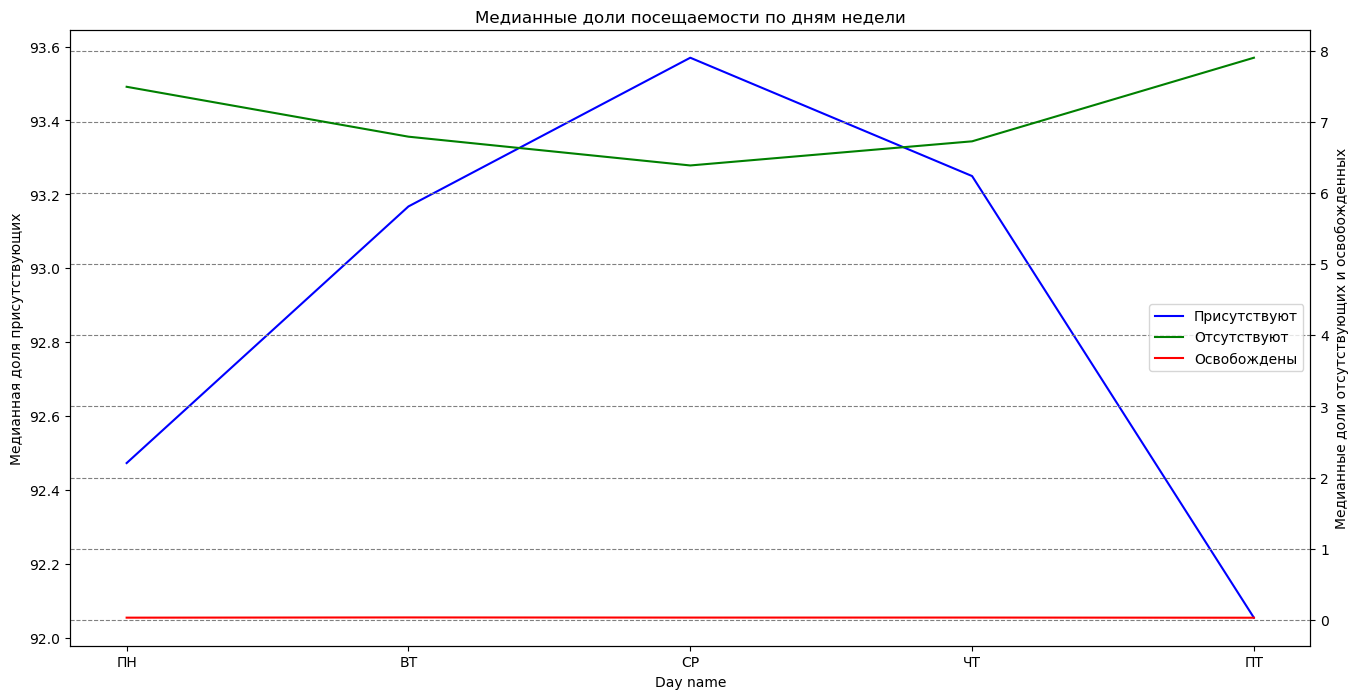

In [31]:
fig, ax1 = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_sum_weekly,
             x='Day name', y='Present pct median',
             ax=ax1, color='Blue', label='Присутствуют')
ax1.set_ylabel('Медианная доля присутствующих')

ax2 = plt.twinx()
sns.lineplot(data=df_sum_weekly,
             x='Day name', y='Absent pct median',
             ax=ax2, color='Green', label='Отсутствуют')
sns.lineplot(data=df_sum_weekly,
             x='Day name', y='Released pct median',
             ax=ax2, color='Red', label='Освобождены')
ax2.set_ylabel('Медианные доли отсутствующих и освобожденных')

plt.xlabel('День недели')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.get_legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.grid(True, color='grey', linestyle='--')
plt.title('Медианные доли посещаемости по дням недели')
plt.show()

Оба графика показывают, что посещаемость ниже всего в начале и конце недели (ПН и ПТ). Максимум посещаемости наблюдается в среду.

### 4. Анализ выбросов.

Посмотрим на отброшенные данные о посещаемости и постараемся понять, почему в них наблюдается аномально низкая посещаемость.

Сначала посмотрим на общие статистические характеристики и сравним их с регулярными данными.

Данных мало, поэтому можно просто вызвать describe().

In [32]:
df_outliers.describe()


,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct
count,22722,22722.000000,22722.000000,22722.000000,22722.000000,22722.000000,22722.000000,22722.000000
mean,2019-02-26 12:35:21.785054208,373.178109,109.992474,241.976014,21.209621,64.430393,32.149973,3.419635
min,2018-09-05 00:00:00,15.000000,0.000000,1.000000,0.000000,0.046253,0.000000,0.000000
25%,2018-12-17 00:00:00,196.000000,62.000000,120.000000,0.000000,57.872558,23.869053,0.000000
50%,2019-03-01 00:00:00,296.000000,87.000000,193.000000,0.000000,68.773234,29.525684,0.000000
75%,2019-05-28 00:00:00,451.000000,130.000000,298.000000,0.000000,75.142857,39.444444,0.000000
max,2019-06-26 00:00:00,5908.000000,2151.000000,3490.000000,5904.000000,78.684211,99.675325,99.939614
std,NaN,324.827341,101.068949,222.419669,120.682015,13.914020,13.058534,14.189032


In [33]:
df.describe()

,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct
count,254431,254431.000000,254431.000000,254431.000000,254431.000000,254431.000000,254431.000000,254431.000000
mean,2019-01-25 22:07:30.482842112,616.973384,45.190869,571.516301,0.266214,92.057000,7.894536,0.048463
min,2018-09-04 00:00:00,1.000000,0.000000,1.000000,0.000000,78.688525,0.000000,0.000000
25%,2018-11-09 00:00:00,346.000000,22.000000,314.000000,0.000000,89.646299,4.664723,0.000000
50%,2019-01-25 00:00:00,489.000000,36.000000,451.000000,0.000000,93.067591,6.896552,0.000000
75%,2019-04-08 00:00:00,712.000000,54.000000,665.000000,0.000000,95.312500,10.280374,0.000000
max,2019-06-26 00:00:00,5955.000000,1140.000000,5847.000000,173.000000,100.000000,21.311475,18.983051
std,NaN,489.625032,44.258751,458.459388,2.565810,4.360290,4.330383,0.475111


Сравним распределение числа зарегистрированных учеников каждый день суммарно по всем школам.

In [34]:
df_outliers_sum = df_outliers.loc[:, 'Date':'Released'].groupby(by='Date', as_index=False).sum()

In [35]:
df_sum.head()

,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct,Holiday,Day of week
0,2018-09-04,264,6,258,0,97.727273,2.272727,0.000000,False,1
1,2018-09-05,869010,77116,791672,222,91.100448,8.874006,0.025546,False,2
2,2018-09-06,902879,70639,832053,187,92.155538,7.823750,0.020712,False,3
3,2018-09-07,899452,70641,828679,132,92.131542,7.853782,0.014676,False,4
4,2018-09-12,932662,54697,877865,100,94.124667,5.864611,0.010722,False,2


In [36]:
df_outliers_sum.describe()

,Date,Enrolled,Absent,Present,Released
count,183,183.000000,183.000000,183.000000,183.000000
mean,2019-01-31 09:02:57.049180416,46335.262295,13657.098361,30044.693989,2633.469945
min,2018-09-05 00:00:00,434.000000,156.000000,228.000000,0.000000
25%,2018-11-15 12:00:00,15610.000000,4990.500000,10357.500000,72.000000
50%,2019-02-01 00:00:00,20908.000000,6427.000000,13885.000000,115.000000
75%,2019-04-11 12:00:00,42155.000000,11097.000000,27268.000000,241.500000
max,2019-06-26 00:00:00,696924.000000,267030.000000,427967.000000,58422.000000
std,NaN,75270.286403,25536.617314,47476.903544,8720.463797


In [37]:
df_sum.describe()

,Date,Enrolled,Absent,Present,Released,Present pct,Absent pct,Released pct,Day of week
count,182,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,2019-01-29 18:11:52.087912192,862511.840659,63175.593407,798964.087912,372.159341,92.507073,7.449995,0.042931,2.065934
min,2018-09-04 00:00:00,264.000000,1.000000,258.000000,0.000000,86.370575,0.370370,0.000000,0.000000
25%,2018-11-13 06:00:00,897457.000000,57050.500000,817163.000000,184.000000,91.599393,6.341154,0.020328,1.000000
50%,2019-01-29 12:00:00,923099.000000,62768.000000,854914.500000,255.000000,92.927103,7.033384,0.029391,2.000000
75%,2019-04-11 18:00:00,929545.000000,71691.500000,868419.250000,334.000000,93.611449,8.364262,0.038948,3.000000
max,2019-06-26 00:00:00,936982.000000,94787.000000,887619.000000,12473.000000,99.629630,13.565855,1.351452,4.000000
std,NaN,164992.128354,14036.046046,157491.827851,945.335049,1.848973,1.846036,0.102502,1.389003


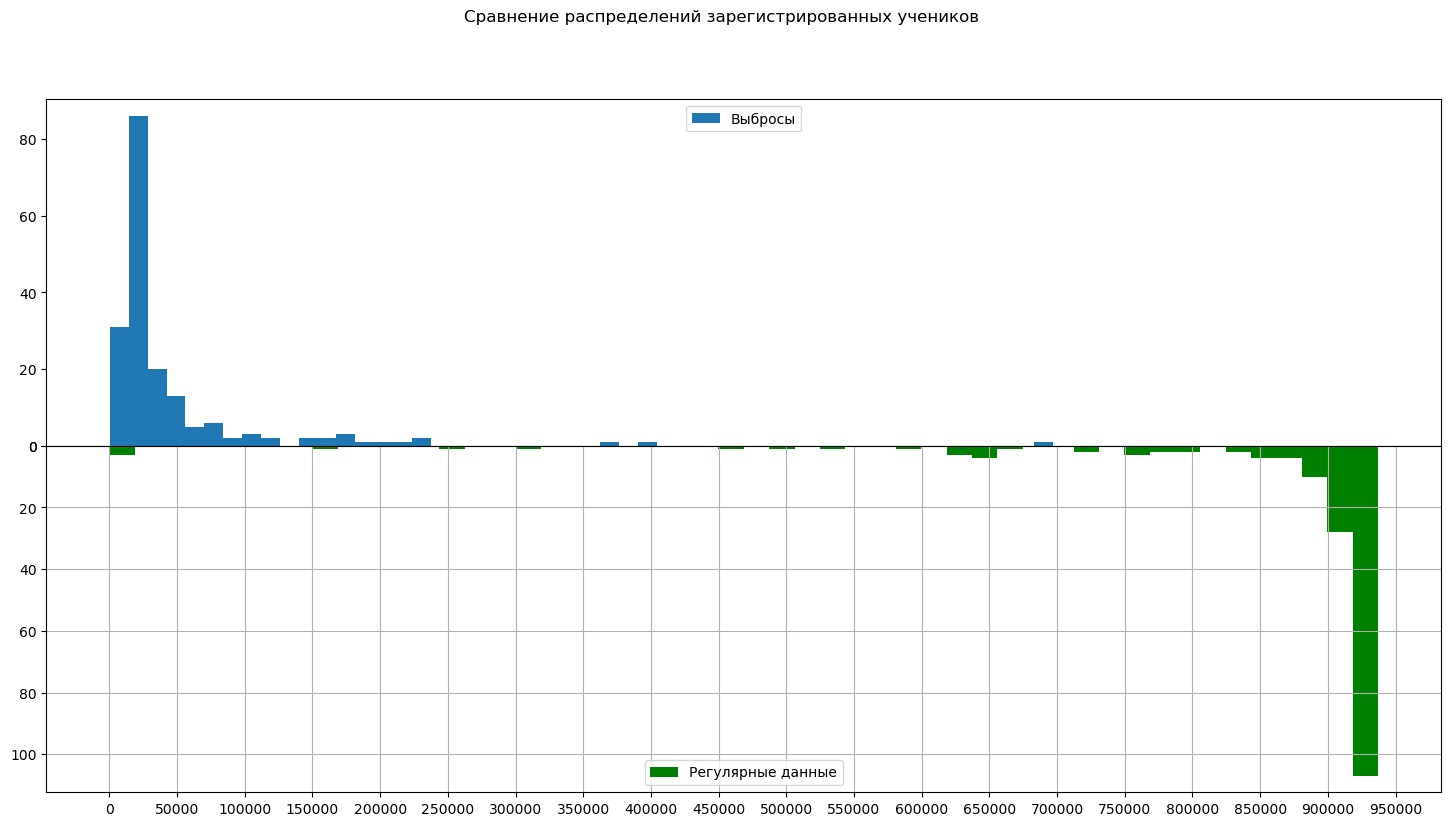

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 9))
plt.subplots_adjust(hspace=0.0)

axs[0].hist(df_outliers_sum['Enrolled'], label='Выбросы', bins=50)
axs[0].set_xticks(ticks=range(0, 100_000_000+1, 50_000))
axs[0].legend(loc='upper center')

axs[1].hist(df_sum['Enrolled'], color='Green', label='Регулярные данные', bins=50)
axs[1].invert_yaxis()
axs[1].legend(loc='lower center')

plt.grid(True)

fig.suptitle(t='Сравнение распределений зарегистрированных учеников', )
plt.show()

Основное отличие отброшенных данных от регулярных заключается в общем числе зарегистрированных учеников. Как видно из гистограммы, отброшенные данные имеют намного меньшие значения о числе учеников. Возможно, основная масса школ объявляет в дни выбросов выходные, что занижает число учеников и подталкивает их к пропуску занятий.

Проверим следующую гипотезу: существует положительная выраженная корелляция между числом работающих школ и посещаемостью. 

In [39]:
df = pd.read_csv(df_filename)
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [40]:
df.head()

,School DBN,Date,Enrolled,Absent,Present,Released
0,01M015,2018-09-05,172,19,153,0
1,01M015,2018-09-06,171,17,154,0
2,01M015,2018-09-07,172,14,158,0
3,01M015,2018-09-12,173,7,166,0
4,01M015,2018-09-13,173,9,164,0


In [41]:
df = df.groupby(by='Date', as_index=False).agg(func={'School DBN': 'count', **{column: 'sum' for column in ['Enrolled', 'Absent', 'Present', 'Released']}})


In [42]:
df = df.rename(columns={'School DBN': 'School count'})

In [43]:
df['Present rate'] = df['Present'] / df['Enrolled']

In [44]:
df.head()

,Date,School count,Enrolled,Absent,Present,Released,Present rate
0,2018-09-04,1,264,6,258,0,0.977273
1,2018-09-05,1583,940701,97715,842673,313,0.895793
2,2018-09-06,1581,943392,82352,860735,305,0.912383
3,2018-09-07,1581,944269,83709,860225,335,0.910996
4,2018-09-12,1581,945677,58220,887153,304,0.938114


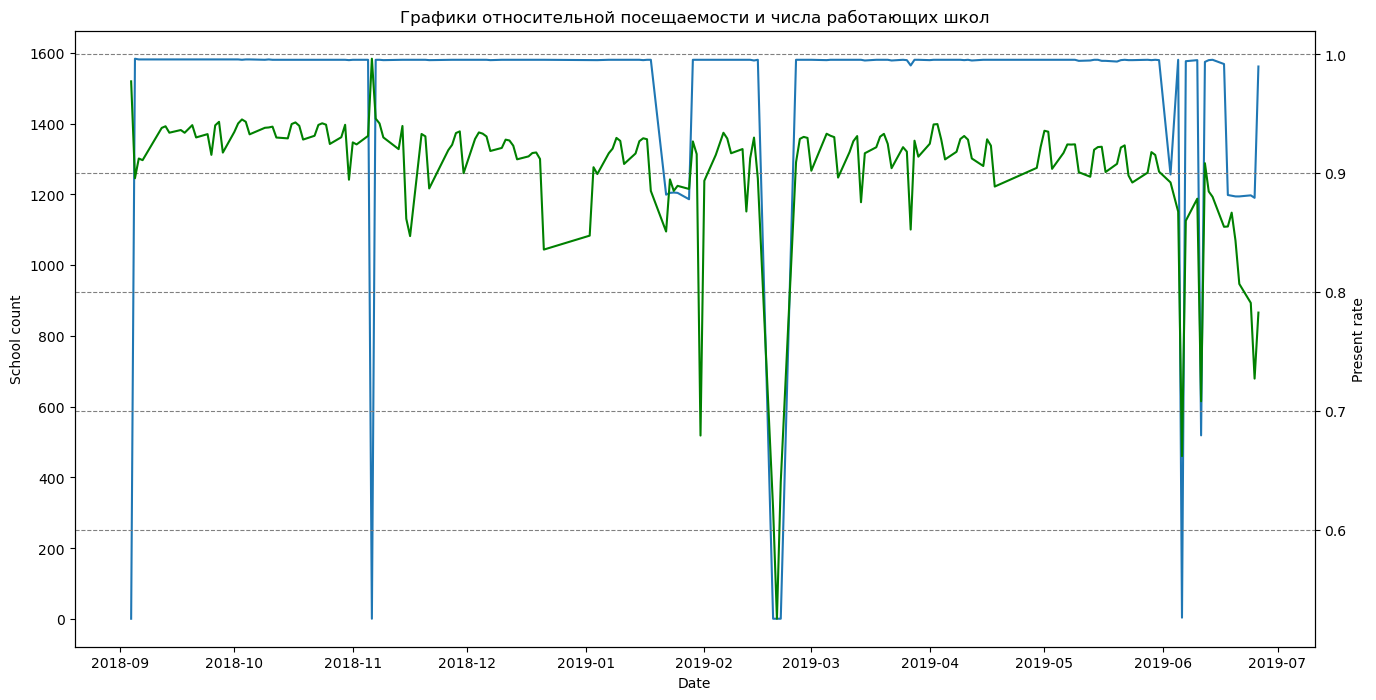

In [45]:
plt.subplots(figsize=(16, 8))

sns.lineplot(data=df, x='Date', y='School count')
ax_2 = plt.twinx()

sns.lineplot(data=df, x='Date', y='Present rate', ax=ax_2, color='Green')

plt.grid(True, color='grey', linestyle='--')

plt.title('Графики относительной посещаемости и числа работающих школ')

plt.show()

In [46]:
from scipy.stats import pearsonr

res = pearsonr(x=df['School count'], y=df['Present rate'])
print(res)

PearsonRResult(statistic=np.float64(0.6312637960923344), pvalue=np.float64(5.846467448706966e-22))


Коэффициент корреляции оказался равен 0.63, что показывает среднюю корреляцию между величинами. Причино-следственная связь в свою очередь остается дискусионной -- данные не позволяют уверенно ответить на вопрос: число работающих школ уменьшается потому, что падает посещаемость или посещаемость падает из-за того, что малое число школ работают.